In [2]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from gmm_dataset import *
from util_hmm_variational_gibbs import *
from util_plots import *
from scipy.stats import invwishart, dirichlet
from torch.distributions.dirichlet import Dirichlet
sys.path.append('/home/hao/Research/probtorch/')
from probtorch.util import expand_inputs
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.5.0a0+3bb8c5e cuda: True


In [3]:
T = 100
K = 3
D = 2
num_particles_rws = 50
mcmc_steps = 1
num_particles_smc = 50
NUM_HIDDEN = 256
NUM_LATENTS = K*K
NUM_OBS = T * K
# training parameters
NUM_SAMPLES = 1
# BATCH_SIZE = 100
NUM_EPOCHS = 40
LEARNING_RATE = 1e-3
CUDA = False

RESTORE = False

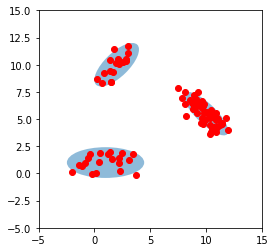

In [4]:
Xs, mu_true, cov_true, Zs_true, Pi_true, A_true = sampling_hmm(T, K, D)
plot_samples(Xs.data.numpy(), mu_true.data.numpy(), cov_true.data.numpy())
Y = Xs

In [5]:
## return samples in order to compute the weights and 
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, num_particles=1):
        A_samples = torch.zeros((K, num_particles, K))
        hidden = self.enc_hidden(obs)
        latents_dirs = torch.exp(self.latent_dir(hidden).view(K, K))
        for k in range(K):
            A_samples[k] = Dirichlet(latents_dirs[k]).sample((num_particles,))
        return latents_dirs, A_samples

In [6]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer

alpha_init_0, alpha_trans_0, m_0, beta_0, nu_0, W_0 = pirors(Y, T, D, K)
enc, optimizer = initialize()
## initialization
cov_ks = torch.zeros((K, D, D))
mu_ks = torch.zeros((K, D))
for k in range(K):
## sample mu_k and Sigma_k randomly
    cov_ks[k] = torch.from_numpy(invwishart.rvs(df=nu_0, scale=W_0.data.numpy())).float()
    mu_ks[k] = MultivariateNormal(loc=m_0, covariance_matrix=cov_ks[k] / beta_0).sample()
Pi = Dirichlet(alpha_init_0).sample()
A_samples = initial_trans(alpha_trans_0, K)

In [8]:
KLs = []
KL_ests = []
log_p_conds = []
log_qs = []
ESSs = []
#     Y, mu_true, cov_true, Zs_true, Pi_true, A_true = sampling_hmm(T, K, D)
Pi = Pi_true
mu_ks = mu_true
cov_ks = cov_true
Z_ret = Zs_true

for epoch in range(NUM_EPOCHS):
    optimizer.zero_grad()

    
    Zs, log_weights, log_normalizer = smc_hmm(Pi, A_samples, mu_ks, cov_ks, Y, T, D, K, num_particles_smc)
    # draw a sample from the sample set 
    Z_ret = resampling_smc(Zs, log_weights)
    latents_dirs, A_samples_new = enc(Z_ret.contiguous().view(-1, T*K), num_particles_rws)
    loss_inference, kl, kl_est, ess= inclusive_kl(A_samples_new, latents_dirs, alpha_init_0, alpha_trans_0, nu_0, W_0, m_0, beta_0, Z_ret, Pi, mu_ks, cov_ks, Y, T, D, K, num_particles_rws)
        
    loss_inference.backward()
    KLs.append(kl.item())
    KL_ests.append(kl_est)
    ESSs.append(ess)
    optimizer.step()
    
#     latents_dirs, A_samples = enc(Z_ret.contiguous().view(-1, T*K), 1)
    A_samples = initial_trans(alpha_trans_0, K)
    print('epoch : %d, KL : %f, kl_est : %f' % (epoch, kl, kl_est))

epoch : 0, KL : 8.543331, kl_est : 1.760073
epoch : 1, KL : 14.796677, kl_est : -32.425236
epoch : 2, KL : 11.602369, kl_est : -14.693318
epoch : 3, KL : 6.852869, kl_est : 4.048211
epoch : 4, KL : 8.953491, kl_est : -5.557538
epoch : 5, KL : 9.273111, kl_est : -10.399015
epoch : 6, KL : 8.467936, kl_est : -8.260195
epoch : 7, KL : 6.699897, kl_est : 1.003553
epoch : 8, KL : 8.822951, kl_est : 1.405248
epoch : 9, KL : 13.610994, kl_est : -11.717591
epoch : 10, KL : 7.883563, kl_est : -1.528966
epoch : 11, KL : 15.812363, kl_est : -13.009917
epoch : 12, KL : 6.488145, kl_est : -3.495138
epoch : 13, KL : 12.878614, kl_est : -7.225792
epoch : 14, KL : 17.147022, kl_est : -2.105236
epoch : 15, KL : 7.203506, kl_est : -3.216754
epoch : 16, KL : 22.435354, kl_est : -22.442465
epoch : 17, KL : 6.220808, kl_est : 2.403211
epoch : 18, KL : 21.971893, kl_est : -37.277290
epoch : 19, KL : 18.533398, kl_est : -10.902710
epoch : 20, KL : 9.520770, kl_est : -4.030931
epoch : 21, KL : 6.868782, kl_es

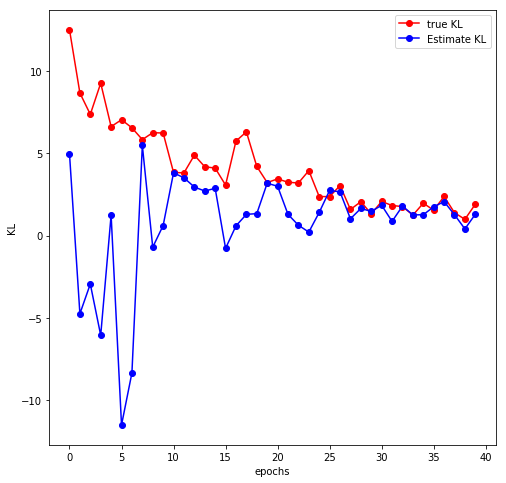

In [21]:
plot_kl_est(np.array(KLs), np.array(KL_ests))

In [22]:
learned_dicichlet_post = latents_dirs
true_dirichlet_post = alpha_trans_0 + pairwise(Z_ret, T).sum(0)
print('variational : ')
print(learned_dicichlet_post)
print('conjugate posterior :')
print(true_dirichlet_post)

variational : 
tensor([[26.5289,  0.5587,  1.9668],
        [ 1.8127, 11.3190,  2.5823],
        [ 1.0213,  2.6391, 30.1144]], grad_fn=<ExpBackward>)
conjugate posterior :
tensor([[28.3333,  0.3333,  4.3333],
        [ 3.3333, 14.3333,  3.3333],
        [ 1.3333,  6.3333, 40.3333]])


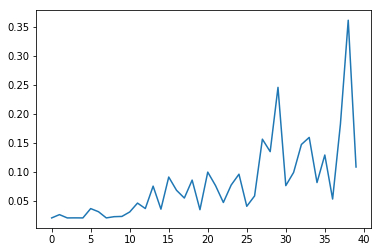

In [23]:
plt.plot(np.array(ESSs) / num_particles_rws)

In [10]:
from torch.distributions.categorical import Categorical
Categorical(torch.Tensor([1/2, 1/2])).sample()

tensor(0)

In [11]:
a = torch.Tensor([1,2,3,4,5])

In [12]:
a[:-1]

tensor([1., 2., 3., 4.])